In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:

%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [3]:
movies_metadata = catalog.load("movies_metadata")

print(movies_metadata.head())

[11/01/25 12:15:53] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=900463;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=907274;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [4]:
# Revisar columnas
print(movies_metadata.columns)

# Crear main_genre
import ast

def get_main_genre(genre_str):
    try:
        genres = ast.literal_eval(genre_str)  
        if isinstance(genres, list) and len(genres) > 0:
            return genres[0]['name']  
        else:
            return None
    except:
        return None

movies_metadata['main_genre'] = movies_metadata['genres'].apply(get_main_genre)

# Revisar si se creó correctamente
print(movies_metadata[['genres', 'main_genre']].head())


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
                                              genres main_genre
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  Animation
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  Adventure
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...    Romance
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...     Comedy
4                     [{'id': 35, 'name': 'Comedy'}]     Comedy


In [5]:
# Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
movies_metadata = catalog.load("movies_metadata")

# Crear la variable objetivo 'high_rating'
movies_metadata['high_rating'] = (movies_metadata['vote_average'] > 6).astype(int)

# Seleccionar columnas numéricas para las características
numeric_cols = ['vote_count', 'popularity', 'runtime', 'budget' ]  
movies_metadata[numeric_cols] = movies_metadata[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
movies_metadata = movies_metadata.dropna(subset=numeric_cols + ['high_rating'])

# Definir X e y
X = movies_metadata[numeric_cols]
y = movies_metadata['high_rating']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predicciones
y_pred = model.predict(X_test_scaled)
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# Métricas de rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClasificación:\n", classification_report(y_test, y_pred))



[11/01/25 12:16:00] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=102195;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=306890;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Accuracy: 0.6050349526590567

Clasificación:
               precision    recall  f1-score   support

           0       0.60      0.73      0.66     11721
           1       0.62      0.47      0.53     10881

    accuracy                           0.61     22602
   macro avg       0.61      0.60      0.60     22602
weighted avg       0.61      0.61      0.60     22602



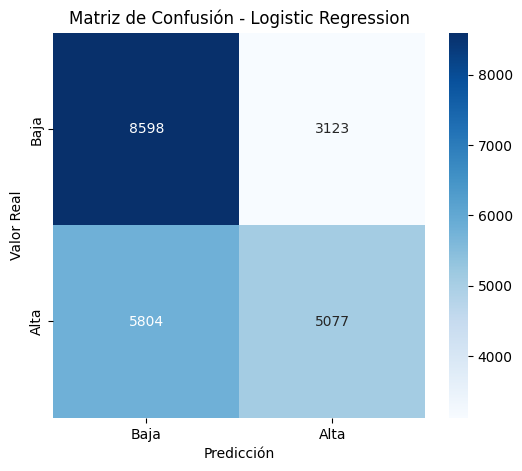

In [6]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()

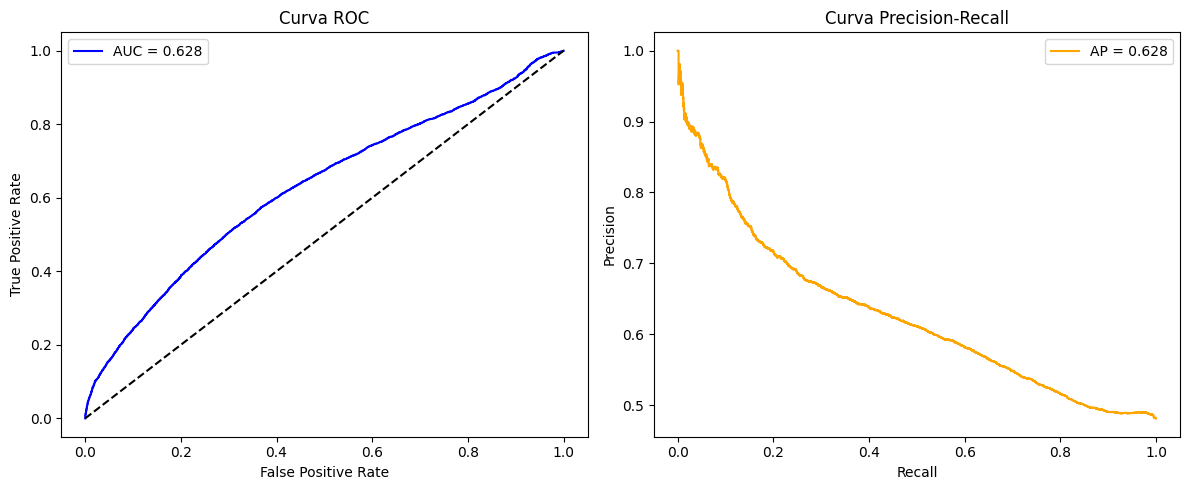

In [7]:

# Curva ROC y Precision-Recall
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Predicción de clases (0 = bajo, 1 = alto)
y_pred = model.predict(X_test_scaled)

# Predicción de probabilidades (opcional)
y_proba = model.predict_proba(X_test_scaled)[:, 1] 


[11/01/25 12:20:29] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=874948;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=721331;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros encontrados:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Accuracy final: 0.6053004158923989

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.60      0.74      0.66     11721
           1       0.62      0.47      0.53     10881

    accuracy                           0.61     22602
   macro avg       0.61      0.60      0.60     22602
weighted avg       0.61      0.61      0.60     22602



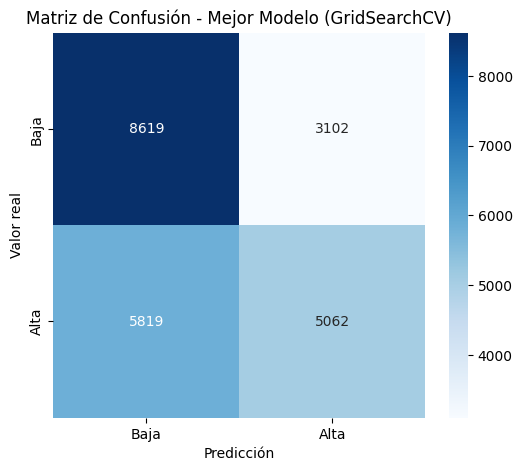

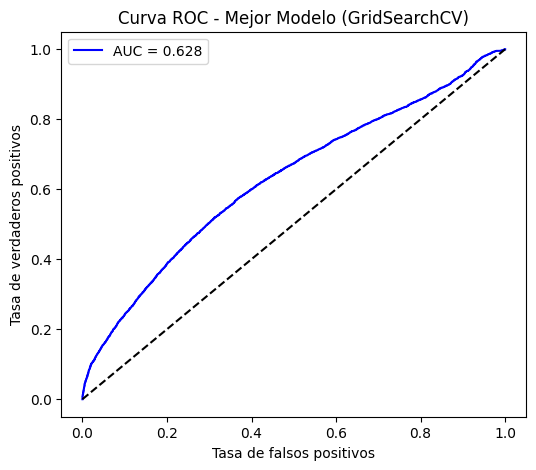

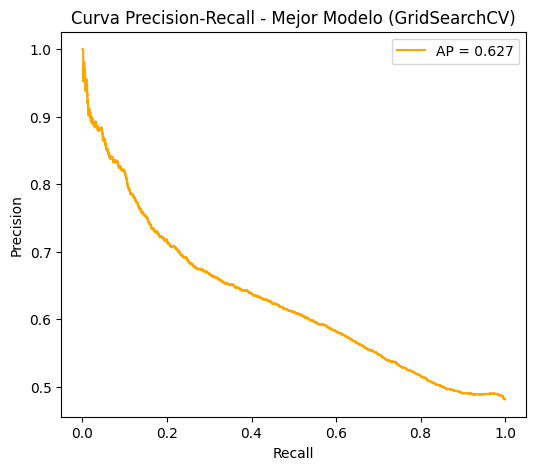

In [10]:
# Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
movies_metadata = catalog.load("movies_metadata")

# Crear variable objetivo
movies_metadata['high_rating'] = (movies_metadata['vote_average'] > 6).astype(int)

# Seleccionar columnas numéricas
numeric_cols = ['vote_count', 'popularity', 'runtime', 'budget']
movies_metadata[numeric_cols] = movies_metadata[numeric_cols].apply(pd.to_numeric, errors='coerce')
movies_metadata = movies_metadata.dropna(subset=numeric_cols + ['high_rating'])

# Definir X e y
X = movies_metadata[numeric_cols]
y = movies_metadata['high_rating']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo base
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],          
    'penalty': ['l1', 'l2'],           
    'solver': ['liblinear', 'saga']    
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Entrenar con búsqueda de hiperparámetros
grid_search.fit(X_train_scaled, y_train)

# Ver mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Modelo final con mejores parámetros
best_model = grid_search.best_estimator_

# Evaluación en test
y_pred = best_model.predict(X_test_scaled)
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy final:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Mejor Modelo (GridSearchCV)')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Mejor Modelo (GridSearchCV)')
plt.legend()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Mejor Modelo (GridSearchCV)')
plt.legend()
plt.show()



Conclusión:
El modelo de clasificación indica que las películas con mayor puntaje promedio (vote_average > 6) pueden predecirse con una precisión moderada (61%) usando variables como vote_count, popularity y runtime. Esto sugiere que el número de votos y la popularidad son factores relevantes para determinar si una película tendrá una calificación alta o baja